In [1]:
%load_ext autoreload
%autoreload 2
    
from d3pm_sc.d3pm import D3PM
from d3pm_sc.d3pm_classic import D3PM_classic
from d3pm_sc.unet import UNet, SimpleUNet
from d3pm_sc.dit import DiT_Llama

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

In [7]:
N = 128  # number of classes for discretized state per pixel
n_T = 1000
n_channel = 3
gamma = 0

s_dim = 4
batch_size = 16

# # Masking
# d3pm = D3PM_classic(DiT_Llama(n_channel, N+1, n_T, False, s_dim=s_dim, dim=1024),
#             n_T, num_classes=N+1, hybrid_loss_coeff=0.01, forward_type='masking').cuda()
# masking = True
# # Uniform
# d3pm = D3PM_classic(UNet(n_channel, N, n_T, False),
#             n_T, num_classes=N, hybrid_loss_coeff=0.01).cuda()
# masking = False
# Schedule conditioning
d3pm = D3PM(SimpleUNet(n_channel, N, n_T, True, s_dim=4),
            n_T, num_classes=N, hybrid_loss_coeff=0.01, gamma=gamma).cuda()
masking = False
print(f"Total Param Count: {sum([p.numel() for p in d3pm.x0_model.parameters()])}")
dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
train_size = int(len(dataset) * 0.9)
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)


Total Param Count: 1935712
Files already downloaded and verified


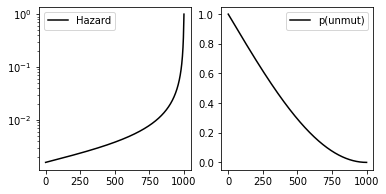

In [8]:
fig, ax = plt.subplots(1, 2, figsize=[6, 3])
ax[0].semilogy(d3pm.beta_t, label="Hazard", color='black')
ax[0].legend()

steps = torch.arange(d3pm.n_T + 1, dtype=torch.float64) / d3pm.n_T
alpha_bar = 1-torch.cos((1 - steps) * torch.pi / 2)
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

optim = torch.optim.AdamW(d3pm.x0_model.parameters(), lr=1e-3)
d3pm.train()

n_epoch = 14
device = "cuda"

global_step = 0
for i in range(n_epoch):

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, cond in pbar:
        optim.zero_grad()
        x = x.to(device)
        cond = cond.to(device)
        x = (x * (N - 1)).round().long().clamp(0, N - 1)
        
        loss, info = d3pm(x, cond)

        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(d3pm.x0_model.parameters(), 0.1)

        # log
        with torch.no_grad():
            param_norm = sum([torch.norm(p) for p in d3pm.x0_model.parameters()])

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.99 * loss_ema + 0.01 * loss.item()
        pbar.set_description(
            f"loss: {loss_ema:.4f}, norm: {norm:.4f}, param_norm: {param_norm:.4f}, vb_loss: {info['vb_loss']:.4f}, ce_loss: {info['ce_loss']:.4f}"
        )
        optim.step()

        global_step += 1
        if global_step % 300 == 1:
            d3pm.eval()
            with torch.no_grad():
                # save images
                cond = torch.arange(0, 4).cuda() % 10
                init_noise = torch.randint(0, N, (4,)+x.shape[1:]).cuda()
                if masking:
                    init_noise = N + 0*init_noise

                images = d3pm.sample_with_image_sequence(
                    init_noise, cond, stride=40
                )
                # image sequences to gif
                gif = []
                for image in images:
                    x_as_image = make_grid(image.float() / (N - 1), nrow=2)
                    img = x_as_image.permute(1, 2, 0).cpu().numpy()
                    img = (img * 255).astype(np.uint8)
                    gif.append(Image.fromarray(img))

                gif[0].save(
                    f"contents/sample_{global_step}.gif",
                    save_all=True,
                    append_images=gif[1:],
                    duration=100,
                    loop=0,
                )

                last_img = gif[-1]
                last_img.save(f"contents/sample_{global_step}_last.png")

                val_loss = []
                for x, cond in test_dataloader:
                    optim.zero_grad()
                    x = x.to(device)
                    cond = cond.to(device)
                    x = (x * (N - 1)).round().long().clamp(0, N - 1)
                    
                    loss, info = d3pm(x, cond)
                    val_loss.append(info['vb_loss'])
                bpd = np.mean(val_loss).round(4)
                print("val bits per dim:", bpd, ", perplexity:", np.exp(bpd).round(4))

            d3pm.train()

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 204.15it/s]
loss: 4.5800, norm: 0.4817, param_norm: 190.7638, vb_loss: 4.2101, ce_loss: 4.93

val bits per dim: 4.8585 , perplexity: 128.8308


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 202.55it/s]
loss: 4.7188, norm: 0.4716, param_norm: 216.3047, vb_loss: 4.7684, ce_loss: 4.63

val bits per dim: 4.5298 , perplexity: 92.74


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.74it/s]
loss: 4.4667, norm: 0.5341, param_norm: 234.2109, vb_loss: 4.2213, ce_loss: 4.47

val bits per dim: 4.2799 , perplexity: 72.2332


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.60it/s]
loss: 4.3209, norm: 0.6405, param_norm: 246.1103, vb_loss: 4.6942, ce_loss: 4.29

val bits per dim: 4.2446 , perplexity: 69.7279


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 202.15it/s]
loss: 4.2519, norm: 1.1057, param_norm: 256.5177, vb_loss: 3.9293, ce_loss: 4.24

val bits per dim: 4.1734 , perplexity: 64.9359


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 202.58it/s]
loss: 4.1530, norm: 1.0295, param_norm: 265.2219, vb_loss: 5.3095, ce_loss: 4.21

val bits per dim: 4.1476 , perplexity: 63.2819


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.61it/s]
loss: 4.1969, norm: 0.7814, param_norm: 273.0186, vb_loss: 3.6317, ce_loss: 4.29

val bits per dim: 4.1551 , perplexity: 63.7583


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.44it/s]
loss: 4.1202, norm: 0.7880, param_norm: 280.6637, vb_loss: 3.7533, ce_loss: 4.09

val bits per dim: 4.074 , perplexity: 58.7917


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 202.21it/s]
loss: 4.1238, norm: 1.1685, param_norm: 287.2982, vb_loss: 4.5958, ce_loss: 4.21

val bits per dim: 4.1322 , perplexity: 62.3149


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.43it/s]
loss: 4.0653, norm: 0.9220, param_norm: 294.0422, vb_loss: 4.1353, ce_loss: 4.01

val bits per dim: 4.006 , perplexity: 54.9267


loss: 4.0772, norm: 1.2430, param_norm: 296.1371, vb_loss: 4.9748, ce_loss: 4.02
100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.34it/s]
loss: 3.9166, norm: 2.3241, param_norm: 299.8633, vb_loss: 3.8886, ce_loss: 4.24

val bits per dim: 3.9538 , perplexity: 52.1331


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.94it/s]
loss: 4.0013, norm: 1.2805, param_norm: 305.6873, vb_loss: 4.1481, ce_loss: 4.13

val bits per dim: 4.0883 , perplexity: 59.6384


 38%|██████████████▋                        | 375/1000 [00:01<00:03, 200.34it/s]

In [126]:
torch.save(d3pm.state_dict(), 'models/d3pm_cifar10_aug10')

RuntimeError: Parent directory models does not exist.

In [5]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

n_samples = 200

cond = torch.zeros(n_samples).cuda().to(torch.int64)
# init_noise = torch.randint(0, N, (n_samples, n_channel, 32, 32)).cuda() # uniform
init_noise = N + 0*torch.randint(0, N, (n_samples, n_channel, 32, 32)).cuda() # masking

images = d3pm.sample_with_image_sequence(
    init_noise, cond, stride=1
)
images = torch.cat([im[None, ...] for im in images], 0)
images = torch.cat([init_noise[None, ...], images], 0)
diffs = (images[1:] != images[:-1]).reshape(n_T-1, n_samples, -1)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 37.50 GiB. GPU 0 has a total capacity of 23.64 GiB of which 764.50 MiB is free. Including non-PyTorch memory, this process has 22.89 GiB memory in use. Of the allocated memory 19.92 GiB is allocated by PyTorch, and 2.79 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Text(0.5, 0, 'Step')

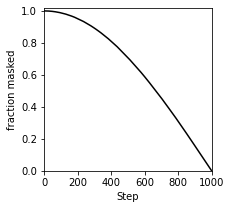

In [93]:
fracs = (images == N).reshape(n_T, n_samples, -1).float().cpu().mean(-1).mean(-1)
plt.figure(figsize=[3, 3])
plt.plot(fracs, color='black')
plt.ylim(0, 1.02)
plt.xlim(0, n_T)
plt.ylabel("fraction masked")
plt.xlabel("Step")

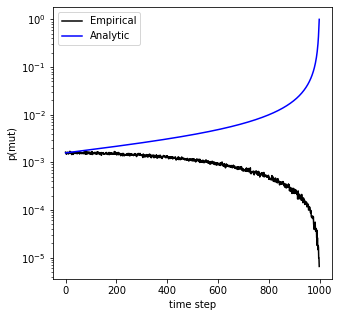

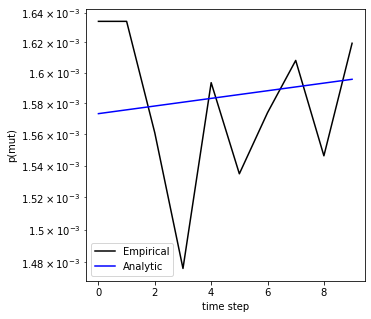

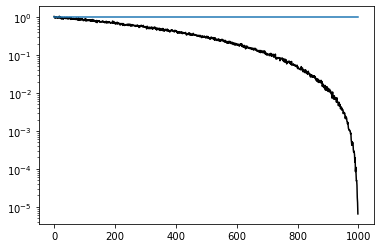

In [89]:
r1 = diffs.cpu().numpy().mean(-1).mean(-1)[::-1]
r2 = d3pm.beta_t[1:].cpu().numpy()# * (1-gamma)
plt.figure(figsize=[5, 5])
plt.semilogy(r1, label="Empirical", color='black')
plt.semilogy(r2, label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
# plt.savefig("figures/schedule_comparison.png")

plt.figure(figsize=[5, 5])
plt.semilogy(r1[:10], label="Empirical", color='black')
plt.semilogy(r2[:10], label="Analytic", color='blue')
plt.xlabel("time step")
plt.ylabel("p(mut)")
plt.legend()
# plt.savefig("figures/schedule_comparison_zoom.png")

plt.figure()
plt.semilogy(r1/r2, color='black')
plt.plot([0, 1000], np.ones(2))